# Perform face classification using VGGface

## 1. First resolving version conflict of the default vggface package

In [4]:
# Resolve version conflict from one of the files
filename = "/home/eric/anaconda3/envs/peekingduckling/lib/python3.8/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import numpy as np
from numpy import asarray
from PIL import Image
import pickle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import os
sys.path.append(str(Path(os.getcwd()).parent.absolute()))
from src.datapipeline.images_to_embeddings import Create_Embeddings
from src.modelling.vggface_model import VGGFace_Model
from src.modelling.knn_model import KNN_Classify

## 2. Download base model

In [34]:
# Loading VGGFace model without classifier and getting output to be a face embedding
base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
# summarize input and output shape
print('Inputs: %s' % base_model.inputs)
print('Outputs: %s' % base_model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_6')>]
Outputs: [<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d_3')>]


## 3. Obtain image embeddings

In [35]:
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(files, model):
	# extract faces
	faces = [f for f in files]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	# perform prediction
	yhat = model.predict(samples)
	return yhat

In [36]:
model = keras.Sequential([
    keras.layers.Resizing(224,224),
    # keras.layers.RandomZoom((-0.2, 0.2), fill_mode='reflect'),
    # keras.layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
    # keras.layers.RandomRotation(0.2, fill_mode='reflect'),
    # keras.layers.RandomFlip(),
    # keras.layers.RandomContrast(0.2),
    base_model,
])

## 4. Compare image embeddings between two different person

In [59]:
image_path = '../data/raw/images/clarence/300_clarence.jpg'
img = Image.open(image_path)

In [60]:
img = np.array(img)
clarence_embedding = get_embeddings([img], model)

In [61]:
clarence_embedding

array([[0.7209997 , 0.        , 0.03487726, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [62]:
image_path = '../data/raw/images/eric_kwok/0_eric_kwok.jpg'
img = Image.open(image_path)

In [63]:
img = np.array(img)
kwok_embedding = get_embeddings([img], model)

In [64]:
kwok_embedding

array([[2.646888 , 0.0573287, 0.       , ..., 5.8668456, 0.       ,
        0.       ]], dtype=float32)

In [65]:
# Comparison of embedding using euclidean distance
diff_dist = np.linalg.norm(clarence_embedding-kwok_embedding)
diff_dist

101.5161

In [66]:
# Comparring using cosine difference (1 - cosine distance)
cos_sim = cosine(clarence_embedding, kwok_embedding)
cos_sim

0.576074093580246

## 5. Compare embeddings for the same person

In [57]:
image_path = '../data/raw/images/clarence/300_clarence.jpg'
img = Image.open(image_path)

img = np.array(img)
clarence_embedding_2 = get_embeddings([img], model)

# Comparison of embedding
diff_dist = np.linalg.norm(clarence_embedding-clarence_embedding_2)
diff_dist

88.50315

In [58]:
# Comparring using cosine distance (1 - cosine similarity)
cos_sim = cosine(clarence_embedding, clarence_embedding_2)
cos_sim

0.46248912811279297

## 6. Get the embeddings from clarence, eric kwok and eric lee

In [127]:
embedding_path = '../data/embedding.pickle'
with open(embedding_path, 'rb') as f:
    embedding_dict = pickle.load(f)

In [128]:
len(embedding_dict['embedding'])

9490

In [129]:
embedding_dict.keys()

dict_keys(['embedding', 'class'])

### 6.1 PCA of the embeddings

In [ ]:
X = normalize(embedding_dict['embedding'], norm='l2', axis=1, copy=True)
y = embedding_dict['class']

In [131]:
pca = PCA()
pca.fit(X)

PCA()

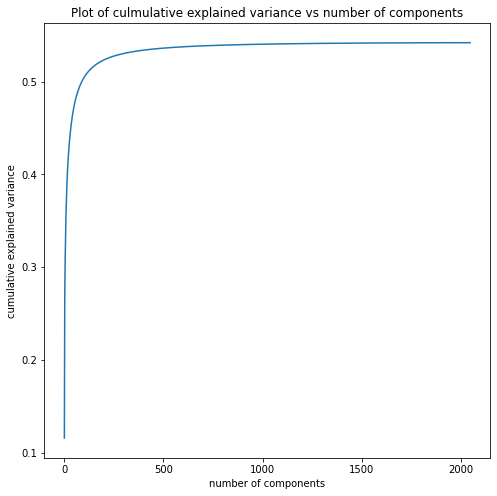

In [132]:
plt.figure(figsize=(8,8))
plt.plot(np.cumsum(pca.explained_variance_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("Plot of culmulative explained variance vs number of components")
plt.show()

In [133]:
X_trans = pca.transform(X)

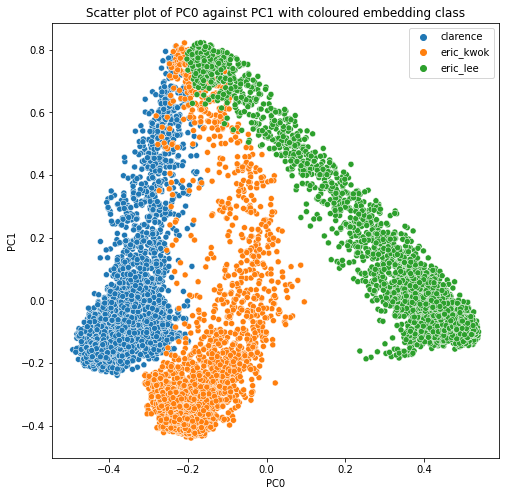

In [134]:
 # Draw scatterplot 
plt.figure(figsize=(8,8))
plt.title("Scatter plot of PC0 against PC1 with coloured embedding class")
plt.xlabel("PC0")
plt.ylabel("PC1")
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y)
current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.legend(current_handles, ["{}".format(i) for i in current_labels])
plt.show()

## 7. Testing of KNN for prediction

### 7.1 Create embeddings for validation images

In [64]:
CE = Create_Embeddings()
CE.load_images_paths('../data/raw/output/val')

In [24]:
VGG_M = VGGFace_Model()
VGG_M.download_model()
model = VGG_M.build_model()

INFO:src.modelling.vggface_model:Proceed to download model...
INFO:src.modelling.vggface_model:Building model...


In [65]:
embedding_dict = CE.build_embedding_db(model)

embeddding progress: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


In [26]:
knn_path = '../models/knn.pickle'
embedding_path = '../data/embedding.pickle'
knn = KNN_Classify(embedding_path, knn_path)

In [27]:
knn.build_model(fit_knn=False)

INFO:src.modelling.knn_model:Getting ../data/embedding.pickle
INFO:src.modelling.knn_model:../data/embedding.pickle successfully loaded
INFO:src.modelling.knn_model:Getting ../models/knn.pickle
INFO:src.modelling.knn_model:../models/knn.pickle successfully loaded


In [28]:
embedding_dict['class'] = np.array(embedding_dict['class'])
embedding_dict['embedding'] = np.array(embedding_dict['embedding'])

In [30]:
y_pred, prob = knn.predict(embedding_dict['embedding'], threshold=0.4)

In [31]:
print(f"Accuracy score: {accuracy_score(embedding_dict['class'], y_pred)}")

Accuracy score: 0.7739872068230277


In [32]:
onehot = OneHotEncoder(sparse=False)
y_true_oh = onehot.fit_transform(embedding_dict['class'].reshape(-1,1))
y_pred_oh = onehot.transform(y_pred.reshape(-1,1))
print(f"F1 score: {f1_score(y_true_oh, y_pred_oh, average='weighted')}")

F1 score: 0.7444777084743636


### 7.2 Test without the class of 'others' 

In [34]:
y = embedding_dict['class']
y_pred, prob = knn.predict(embedding_dict['embedding'][y!='others'], threshold=0.35)

In [35]:
print(f"Accuracy score: {accuracy_score(embedding_dict['class'][y!='others'], y_pred)}")

Accuracy score: 0.9970238095238095


In [36]:
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_true_oh = onehot.fit_transform(embedding_dict['class'][y!='others'].reshape(-1,1))
y_pred_oh = onehot.transform(y_pred.reshape(-1,1))
f1_score(y_true_oh, y_pred_oh, average=None)
print(f"F1 score: {f1_score(y_true_oh, y_pred_oh, average='weighted')}")

F1 score: 0.9985066090493135


### 7.3 PCA of embeddings of validation set without the class of 'others'

In [37]:
X = normalize(embedding_dict['embedding'], norm='l2', axis=1, copy=True)
y = embedding_dict['class']

In [39]:
pca = PCA()
pca.fit(X)

PCA()

In [40]:
X_trans = pca.transform(X)

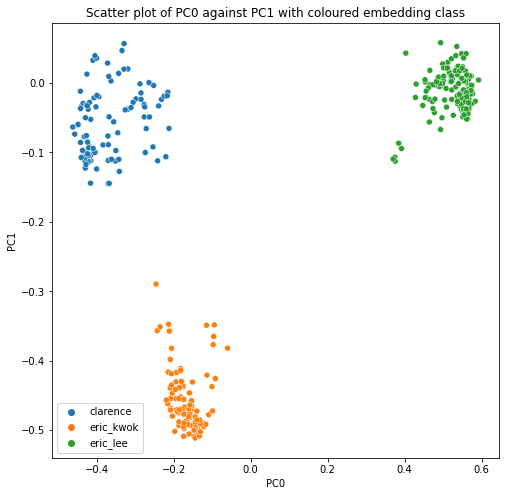

In [41]:
 # Draw scatterplot 
plt.figure(figsize=(8,8))
plt.title("Scatter plot of PC0 against PC1 with coloured embedding class")
plt.xlabel("PC0")
plt.ylabel("PC1")
y = np.array(y)
sns.scatterplot(x=X_trans[y!='others',0], y=X_trans[y!='others',1], hue=y[y!='others'])
current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.legend(current_handles, ["{}".format(i) for i in current_labels])
plt.show()

## 8. Tuning for the best threshold

In [42]:
weighted_f1 = []
acc = []
for t in tqdm(np.linspace(0.3, 0.5, num=200), total=200):
    y_pred, prob = knn.predict(embedding_dict['embedding'], threshold=t)
    weighted_f1.append(f1_score(embedding_dict['class'], y_pred, average='weighted'))
    acc.append(accuracy_score(embedding_dict['class'], y_pred))

100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


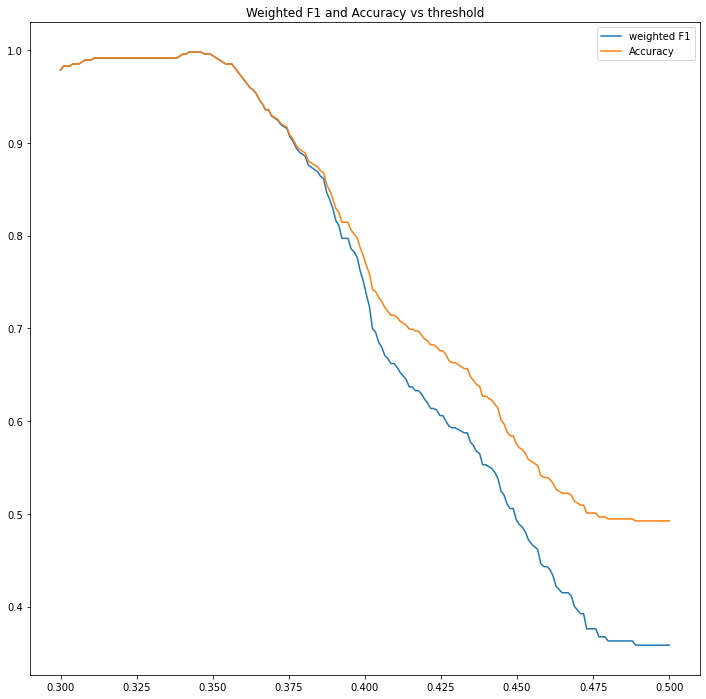

In [43]:
plt.figure(figsize=(12,12))
sns.lineplot(x=np.linspace(0.3, 0.5, num=200), y=weighted_f1)
sns.lineplot(x=np.linspace(0.3, 0.5, num=200), y=acc)
plt.legend(["weighted F1", "Accuracy"])
plt.title("Weighted F1 and Accuracy vs threshold")
plt.show()

In [44]:
thres = np.linspace(0.3, 0.5, num=200)
print(f"Best threshold for Weighted F1 score is {thres[np.argmax(weighted_f1)]}")
print(f"Best threshold for Accuracy score is {thres[np.argmax(acc)]}")

Best threshold for Weighted F1 score is 0.3422110552763819
Best threshold for Accuracy score is 0.3422110552763819


In [66]:
y_pred, prob = knn.predict(embedding_dict['embedding'], threshold=0.3422110552763819)

In [67]:
y_true = embedding_dict['class']

In [68]:
confusion_matrix(y_true, y_pred, labels=np.append(knn.knn.classes_, 'others'))

array([[ 98,   0,   0,   0],
       [  0,  97,   0,   0],
       [  0,   0, 141,   0],
       [  0,   0,   1, 132]])

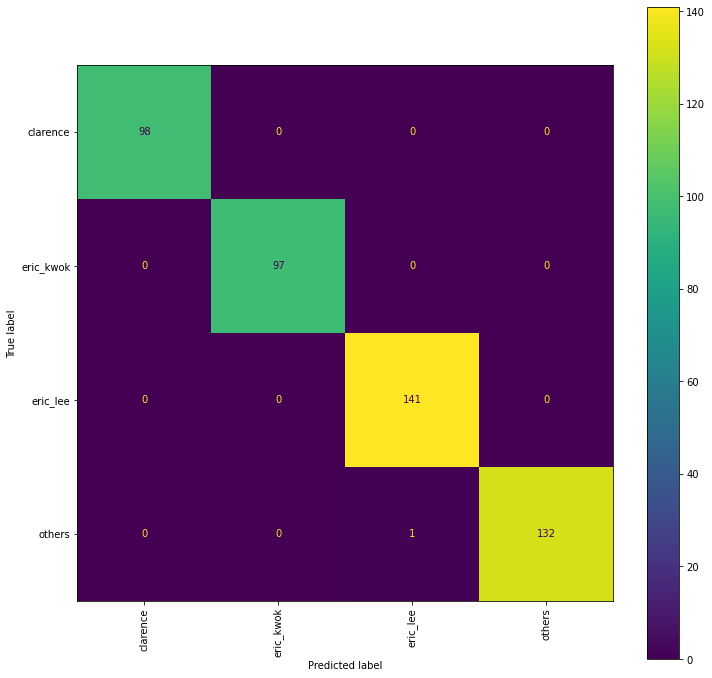

In [69]:
labels = np.append(knn.knn.classes_, 'others')
cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

## 8. Obtaining test scores

In [49]:
CE = Create_Embeddings()
CE.load_images_paths('../data/raw/output/test')

In [50]:
embedding_dict = CE.build_embedding_db(model)

embeddding progress: 100%|██████████| 13592/13592 [13:55<00:00, 16.27it/s]


In [60]:
y_pred, prob = knn.predict(embedding_dict['embedding'], threshold=0.3422110552763819)

In [61]:
print(f"Accuracy score: {accuracy_score(embedding_dict['class'], y_pred)}")

onehot = OneHotEncoder(sparse=False)
y_true_oh = onehot.fit_transform(np.array(embedding_dict['class']).reshape(-1,1))
y_pred_oh = onehot.transform(np.array(y_pred).reshape(-1,1))
print(f"F1 score: {f1_score(y_true_oh, y_pred_oh, average='weighted')}")

Accuracy score: 0.9938198940553267
F1 score: 0.9939193635525992


In [62]:
y_true = embedding_dict['class']
confusion_matrix(y_true, y_pred, labels=np.append(knn.knn.classes_, 'others'))

array([[  183,     0,     0,     0],
       [    0,   178,     0,     1],
       [    0,     0,   106,    24],
       [    6,    22,    31, 13041]])

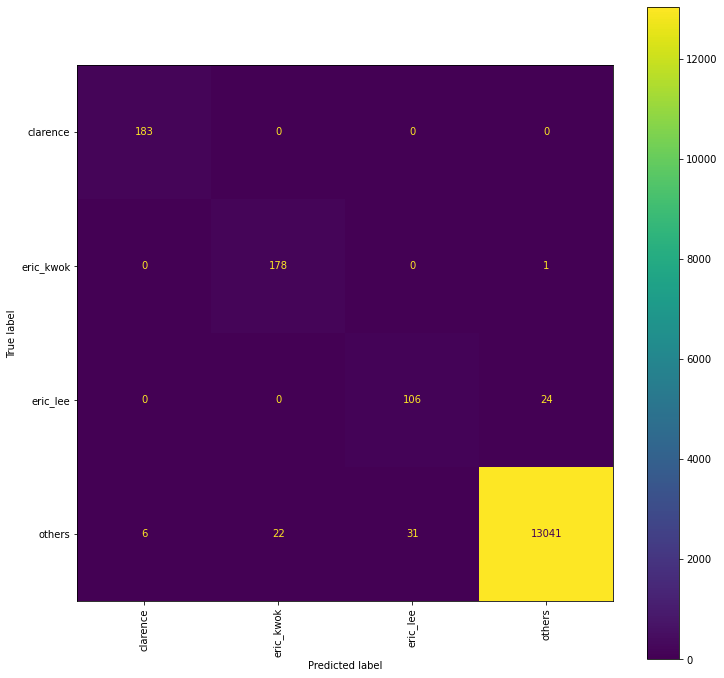

In [63]:
labels = np.append(knn.knn.classes_, 'others')
cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()